In [63]:
"""
Created on Fri Mar 11 10:45:01 2022

@author: leotc
"""

from numpy import *
from math import isclose
import os 
import statistics
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [64]:
# sorry, was lazy with directory
totalpoints = open("C:/Users/leotc/Documents/Uni/PHYS3080/Distance_Ladder/Data/Camera Images/calibrated star data.txt", "r")      
pointdata = totalpoints.readlines()[1:]

In [65]:
distance = []
periods = []
luminosity = []

for i in pointdata:
    
    i = i.split()
    period = i[-2]
    green_flux = i[4]
    dist = i[-3]
    
    if float(period) != 0: 
        periods.append(float(period))
        abs_mag = np.log10(float(green_flux)) + 2*np.log10(float(dist))
        luminosity.append(abs_mag)

Text(0.5, 1.0, 'all period lum relations')

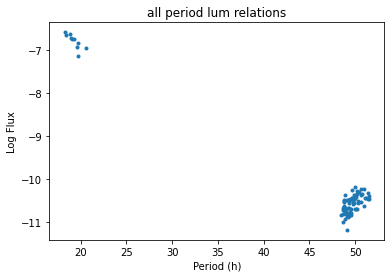

In [66]:
plt.scatter(periods, luminosity, marker='.')
plt.xlabel('Period (h)')
plt.ylabel('Log Flux')
plt.title('all period lum relations')

In [100]:
distance = []
long_periods = []
long_luminosity = []

for i in pointdata:
    
    i = i.split()
    period = i[-2]
    green_flux = i[4]
    dist = i[-3]
    
    if float(period) > 35: 
        long_periods.append(float(period))
        abs_mag = np.log10(float(green_flux)) + 2*np.log10(float(dist))
        long_luminosity.append(abs_mag)

In [101]:
long_fit = np.polyfit(long_periods, long_luminosity, 1)
long_poly = np.poly1d(long_fit)

- For stars with long periods (~50hrs), the relation is given as: <br />
## $ Log (Flux) = 0.14836345*P - 17.94644976 $ <br />
- explicitly:
## $ distance_{long}(pc) = \sqrt{\frac{10^{0.14836345*P (hours) - 17.94644976}}{green flux (W)}} $

Text(0.5, 1.0, 'long period lum relations')

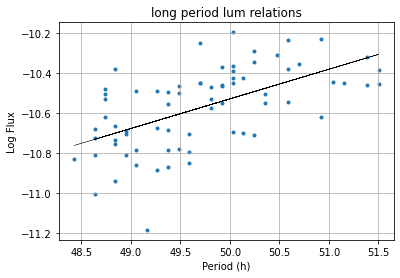

In [109]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(long_periods, long_luminosity, marker='.')
ax1.plot(long_periods,long_poly(long_periods),"k",  linewidth=0.3)
ax1.grid()
plt.xlabel('Period (h)')
plt.ylabel('Log Flux')
plt.title('long period lum relations')

In [83]:
distance = []
short_periods = []
short_luminosity = []

for i in pointdata:
    
    i = i.split()
    period = i[-2]
    green_flux = i[4]
    dist = i[-3]
    
    if float(period) < 35 and float(period) != 0: 
        short_periods.append(float(period))
        abs_mag = np.log10(float(green_flux)) + 2*np.log10(float(dist))
        short_luminosity.append(abs_mag)

In [84]:
short_fit = np.polyfit(short_periods, short_luminosity, 1)
short_poly = np.poly1d(short_fit)

- For stars with short periods (~50hrs), the relation is given as: <br />
## $ Log(Flux) = 0.20472512*P - 2.856877 $ <br />
- explicitly:
## $ distance_{short}(pc) = \sqrt{\frac{10^{0.20472512*P (hours) - 2.856877}}{green flux (W)}} $

Text(0.5, 1.0, 'short period lum relations')

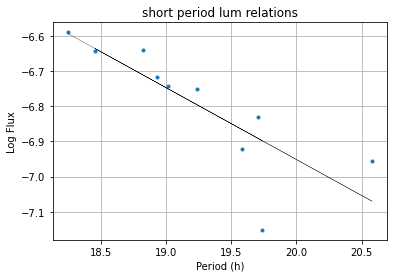

In [108]:
fig = plt.figure()
ax2 = fig.add_subplot(111)

ax2.scatter(short_periods, short_luminosity, marker='.')
ax2.plot(short_periods,short_poly(short_periods),"k", linewidth=0.3)
ax2.grid()
plt.xlabel('Period (h)')
plt.ylabel('Log Flux')
plt.title('short period lum relations')